In [1]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

config = load_config('./HBiLSTM_CL.json')

In [63]:
import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # First BiLSTM layer
        self.bilstm1 = nn.LSTM(input_size, hidden_size//2, batch_first=True, bidirectional=True)
        
        # Second BiLSTM layer
        self.bilstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, bidirectional=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x, lengths):
        packed_sequences = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)
        
        # Apply the first BiLSTM layer
        outputs, _ = self.bilstm1(packed_sequences)
        
        # Apply the second BiLSTM layer
        outputs, _ = self.bilstm2(outputs)
        
        # Unpack the sequences
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        # Apply dropout
        outputs = self.dropout(outputs)
        
        # Pass through the fully connected layer
        logits = self.fc(outputs)
        
        
        return logits


In [64]:
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class SequenceClassificationDataset(Dataset):
    def __init__(self, file_path, max_doc_length=50):
        self.l_mapper = {
            "Fact": 0,
            "ArgumentPetitioner": 1,
            "ArgumentRespondent": 1,
            "RulingByPresentCourt": 2,
            "RulingByLowerCourt": 3,
            "RatioOfTheDecision": 4,
            "None": -1,
            "Statute": 5,
            "PrecedentReliedUpon": 6,
            "PrecedentNotReliedUpon": 6,
            "PrecedentOverruled": 6,
            "Issue": 0,
            "Dissent": 0
        }
        self.file_path = file_path
        self.max_doc_length = max_doc_length
        self.data = self.load_documents()
        self.process_data()
        
    def load_documents(self):
            with open(self.file_path, "rb") as file:
                data_dict = pickle.load(file)
            return [(doc_name, doc_data) for doc_name, doc_data in data_dict.items()]
    
    def process_data(self):
        self.documents = []
        self.doc_lengths = []
        self.doc_labels = []
        
        for doc_name, doc_data in self.data:
            doc_emb = doc_data["embeddings"]
            doc_label = doc_data["labels"]
            doc_label = [self.l_mapper[l] for l in doc_label]
            if len(doc_emb) <= self.max_doc_length:
                self.documents.append(doc_emb)
                self.doc_lengths.append(len(doc_emb))
                self.doc_labels.append(doc_label)
            else:
                num_splits = len(doc_emb) // self.max_doc_length
                remainder = len(doc_emb) % self.max_doc_length

                # Split embeddings
                for i in range(num_splits):
                    start_idx = i * self.max_doc_length
                    end_idx = start_idx + self.max_doc_length
                    self.documents.append(doc_emb[start_idx:end_idx])
                    self.doc_lengths.append(self.max_doc_length)
                    self.doc_labels.append(doc_label[start_idx:end_idx])

                # Handle the remainder
                if remainder > 0:
                    self.documents.append(doc_emb[-remainder:])
                    self.doc_lengths.append(remainder)
                    self.doc_labels.append(doc_label[-remainder:])

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = self.doc_labels[index]
        return document, label

    def collate_fn(self, batch):
        # Sort the batch by document length in descending order
        batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
        documents, labels = zip(*batch)
        
        # Convert documents to tensors
        documents = [torch.tensor(doc) for doc in documents]
        
        # Calculate the actual lengths of the sequences
        lengths = [len(doc) for doc in documents]  
        
        # Pad sequences within the batch
        padded_documents = pad_sequence(documents, batch_first=True)

        # Convert labels to a tensor
        label_tensors = [torch.tensor(label) for label in labels]
        label_tensor = torch.cat(label_tensors)
        
        return padded_documents, label_tensor, lengths

In [65]:
cl_train_dataset = SequenceClassificationDataset('../../data/bert_sentence_independent_embeddings/CL_train.pkl')
cl_dev_dataset = SequenceClassificationDataset('../../data/bert_sentence_independent_embeddings/CL_dev.pkl')
cl_test_dataset = SequenceClassificationDataset('../../data/bert_sentence_independent_embeddings/CL_dev.pkl')


In [66]:
batch_size=3
train_dataloader = DataLoader(cl_train_dataset, batch_size=batch_size, collate_fn=cl_train_dataset.collate_fn)
valid_dataloader = DataLoader(cl_dev_dataset, batch_size=batch_size, collate_fn=cl_dev_dataset.collate_fn)
test_dataloader = DataLoader(cl_test_dataset, batch_size=batch_size, collate_fn=cl_test_dataset.collate_fn)

In [67]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

device used: cpu


In [68]:
# Instantiate the model
input_size = 768
hidden_size = 100
num_classes = 7

model = BiLSTMModel(input_size, hidden_size, num_classes)
model.to(device)

BiLSTMModel(
  (bilstm1): LSTM(768, 50, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=7, bias=True)
)

In [69]:
lr = config['training']['learning_rate']
max_grad_norm = config['training']['max_grad_norm']
epochs = config['training']['epochs']

num_total_steps = len(train_dataloader)*epochs
num_warmup_steps = config['training']['num_warmup_steps']
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1

from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=True)
#epoch_scheduler = StepLR(optimizer, step_size=1, gamma=config['training']["lr_epoch_decay"])

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_total_steps)

In [70]:
seed_val = config['training']['seed']
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [71]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cpu


BiLSTMModel(
  (bilstm1): LSTM(768, 50, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=7, bias=True)
)

In [72]:
def training_step(model, criterion, optimizer, scheduler, data_loader):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for embeddings, labels, lengths in data_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(embeddings, lengths)
        max_sequence_length = output.size(1)
        tlengths = torch.tensor(lengths).unsqueeze(1)
        mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
        masked_output = output[mask]
        
        # Calculate loss
        loss = criterion(masked_output, labels)
        train_loss += loss.item()
        
        # Calculate accuracy
        predicted_labels = masked_output.argmax(dim=-1)
        correct = (predicted_labels == labels).sum().item()
        train_correct += correct
        train_total += labels.shape[0]
        
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    # Calculate epoch statistics
    train_loss /= len(data_loader)
    train_accuracy = train_correct / train_total
    
    return train_loss, train_accuracy


def validation_step(model, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0

    for embeddings, labels, lengths in data_loader:
        with torch.no_grad():
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(embeddings, lengths)
            max_sequence_length = outputs.size(1)
            tlengths = torch.tensor(lengths).unsqueeze(1)
            mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
            masked_output = outputs[mask]
            
            # Calculate loss
            loss = criterion(masked_output, labels)
            dev_loss += loss.item()
            
            # Calculate accuracy
            predicted_labels = masked_output.argmax(dim=-1)
            correct = (predicted_labels == labels).sum().item()
            dev_correct += correct
            dev_total += labels.shape[0]
    
    # Calculate epoch statistics
    dev_loss /= len(data_loader)
    dev_accuracy = dev_correct / dev_total
    
    return dev_loss, dev_accuracy


In [73]:
train_epoch_losses = []
train_epoch_acc = []

dev_epoch_losses = []
dev_epoch_acc = []

# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    
    # Training
    train_loss, train_accuracy = training_step(model, criterion, optimizer, scheduler, train_dataloader)
    train_epoch_losses.append(train_loss)
    train_epoch_acc.append(train_accuracy)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    
    # Validation
    dev_loss, dev_accuracy = validation_step(model, criterion, valid_dataloader)
    dev_epoch_losses.append(dev_loss)
    dev_epoch_acc.append(dev_accuracy)
    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {dev_loss:.4f} - Validation Accuracy: {dev_accuracy:.4f}")


======== Epoch 1 / 300 ========
Epoch 1/300 - Training Loss: 1.8774 - Train Accuracy: 0.1979
Epoch 1/300 - Validation Loss: 1.7867 - Validation Accuracy: 0.2066
======== Epoch 2 / 300 ========
Epoch 2/300 - Training Loss: 1.7113 - Train Accuracy: 0.2549
Epoch 2/300 - Validation Loss: 1.7182 - Validation Accuracy: 0.2052
======== Epoch 3 / 300 ========
Epoch 3/300 - Training Loss: 1.6647 - Train Accuracy: 0.2652
Epoch 3/300 - Validation Loss: 1.7113 - Validation Accuracy: 0.2066
======== Epoch 4 / 300 ========
Epoch 4/300 - Training Loss: 1.6594 - Train Accuracy: 0.2713
Epoch 4/300 - Validation Loss: 1.7055 - Validation Accuracy: 0.2066
======== Epoch 5 / 300 ========
Epoch 5/300 - Training Loss: 1.6586 - Train Accuracy: 0.2666
Epoch 5/300 - Validation Loss: 1.7050 - Validation Accuracy: 0.2066
======== Epoch 6 / 300 ========
Epoch 6/300 - Training Loss: 1.6520 - Train Accuracy: 0.2590
Epoch 6/300 - Validation Loss: 1.7209 - Validation Accuracy: 0.2080
======== Epoch 7 / 300 ========
Ep

KeyboardInterrupt: 

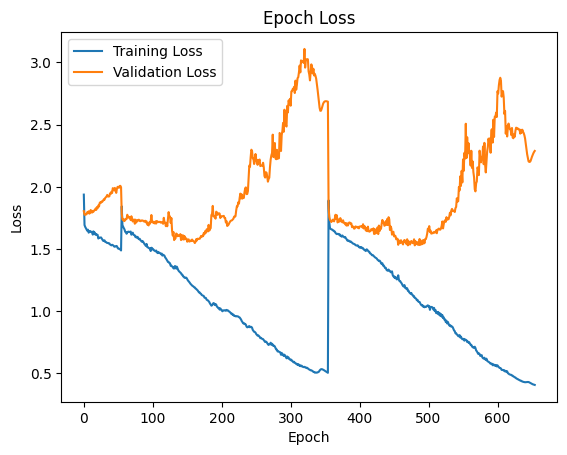

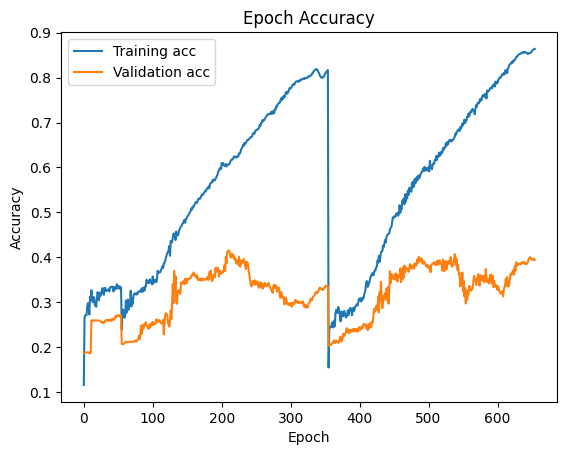

In [73]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses, label='Training Loss')
plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_acc, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [74]:
from sklearn.metrics import classification_report

def testing_step(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    for embeddings, labels, lengths in data_loader:
        with torch.no_grad():
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(embeddings, lengths)
            max_sequence_length = outputs.size(1)
            tlengths = torch.tensor(lengths).unsqueeze(1)
            mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
            masked_output = outputs[mask]
            
            # Calculate loss
            loss = criterion(masked_output, labels)
            test_loss += loss.item()
            
            # Store predictions and true labels
            predicted_labels = masked_output.argmax(dim=-1)
            predictions.extend(predicted_labels.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

            # Calculate accuracy
            correct = (predicted_labels == labels).sum().item()
            test_correct += correct
            test_total += labels.shape[0]

    test_loss /= len(data_loader)
    test_accuracy = test_correct / test_total

    print(f"Testing Loss: {test_loss:.4f} - Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(true_labels, predictions))
    return test_loss, test_accuracy, predictions, true_labels

In [75]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(model, test_dataloader, criterion)

Testing Loss: 2.2883 - Testing Accuracy: 0.3938
              precision    recall  f1-score   support

           0       0.32      0.55      0.41       252
           1       0.76      0.32      0.45       580
           2       0.58      0.61      0.59        18
           3       0.00      0.00      0.00        56
           4       0.34      0.45      0.38       288
           5       0.58      0.57      0.57        58
           6       0.22      0.36      0.27       142

    accuracy                           0.39      1394
   macro avg       0.40      0.41      0.38      1394
weighted avg       0.50      0.39      0.40      1394

